In [5]:
import json
import os
import numpy as np
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

import argparse
import torch
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader

from sklearn.linear_model import LinearRegression

from Utilities import score
from Utilities import plot_matrix_runs, plot_results, save_plot_losses
from Utilities import Add_ID_Count_Neighbours, PairData, prepare_dataloader_distance_scale

from training import training_loop



In [2]:
import torch
from torch.nn import Linear, Parameter, PairwiseDistance, CosineSimilarity
from torch_geometric.nn import MessagePassing, global_mean_pool, GCNConv
from torch_geometric.nn.norm import BatchNorm

In [3]:
# Setup device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
# Load the homomorphism counts vectors:
name_dataset = 'ENZYMES'
n_homs=44
hom_counts_path = 'data/homomorphism_counts/' + name_dataset + "_" + str(n_homs) + ".homson"
if not os.path.exists(hom_counts_path):
    raise FileNotFoundError(f"The file '{hom_counts_path}' was not found.")

# Load dataset
dataset = TUDataset(root='/tmp/ENZYMES', name='ENZYMES', pre_transform=Add_ID_Count_Neighbours(), use_node_attr=True)

Extracting /tmp/ENZYMES/ENZYMES/ENZYMES.zip
Processing...
Done!


# Add Batch Normalisation to the model

In [10]:
class GCN3(torch.nn.Module):
    """
    Takes as input a pair of graphs which are both fed through 3 convolutional layers each followed by an activation function.
    Here 3 graph convolutional layers were used, without any form of parameter sharing.
    Specify the distance matrix as one of cosine, L1, L2.
    Also includes a batch normalisation layer after each ReLU activation function.
    """
    def __init__(self, input_features, hidden_channels, output_embeddings, name, dist = 'L2'):
        super(GCN3, self).__init__()

        self.dist = dist

        self.conv1 = GCNConv(input_features, hidden_channels)
        self.bn1 = BatchNorm(hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.bn2 = BatchNorm(hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, output_embeddings)
        self.name = name
        
        if self.dist not in ['cosine', 'L1', 'L2']:
            raise ValueError("Invalid value for 'dist'. Expected 'cosine', 'L1', or 'L2'.")
        elif self.dist == 'L1':
            self.pdist = PairwiseDistance(p=1)
        elif self.dist == 'L2':
            self.pdist = PairwiseDistance(p=2)
        elif self.dist == 'cosine':
            self.pdist = CosineSimilarity()


    def forward(self, x1, edge_index1, batch1, x2, edge_index2, batch2): # Need a way to extract these from dataloader
        # 1. Obtain node embeddings for graph 1
        x1 = self.conv1(x1, edge_index1)
        x1 = x1.relu()
        x1 = self.bn1(x1)
        x1 = self.conv2(x1, edge_index1)
        x1 = x1.relu()
        x1 = self.bn2(x1)
        x1 = self.conv3(x1, edge_index1)
        # 2. Readout layer
        x1 = global_mean_pool(x1, batch1)  # [batch_size, hidden_channels]
        # 3. Apply a final linear transformation on the aggregated embedding
        x1 = torch.nn.functional.dropout(x1, p=0.5)
        x1 = self.lin(x1)

        # 1. Obtain node embeddings for graph 2
        x2 = self.conv1(x2, edge_index2)
        x2 = x2.relu()
        x2 = self.bn1(x2)
        x2 = self.conv2(x2, edge_index2)
        x2 = x2.relu()
        x2 = self.bn2(x2)
        x2 = self.conv3(x2, edge_index2)
        # 2. Readout layer
        x2 = global_mean_pool(x2, batch2)  # [batch_size, hidden_channels]
        # 3. Apply a final linear transformation on the aggregated embedding
        x2 = torch.nn.functional.dropout(x2, p=0.5)
        x2 = self.lin(x2)
        if self.dist == 'cosine':
            vdist = 1 - self.pdist(x1, x2)
        else:
            vdist = self.pdist(x1, x2)
        return vdist
    
    def save(self):
        """
        Saves the model state dictionary in models folder
        """
        path = 'models/' + self.name + '.pt'
        torch.save(self.state_dict(), path)

In [11]:
batch_size = 32
distance = 'L1'
distance_scaling = 'counts'
train_loader, val_loader, test_loader = prepare_dataloader_distance_scale(hom_counts_path, dataset, batch_size=32, dist=distance, device = device, scaling = distance_scaling, scale_y=True)
hid_size = 32
emb_size = n_homs
lr = 0.01

In [8]:
# Prepare the model: GCN3
name = 'GCN3_batch_norm'
model = GCN3(input_features=dataset.num_node_features, hidden_channels=hid_size, output_embeddings=emb_size, name=name, dist=distance).to(device)
#model = GCN_k_m(input_features=dataset.num_node_features, hidden_channels=hid_size, output_embeddings=emb_size, n_conv_layers=2, n_linear_layers=1, p=0.2, name = name, apply_relu_conv=False, dist='cosine', mlp_dist=True).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.MSELoss().to(device)

train_losses, validation_losses = training_loop(model, train_loader, optimizer, criterion, val_loader, epoch_number=100, patience=10, return_losses=True)

Epoch: 10 | Time for 10 epochs: 0m 58s
	Train Loss: 0.031
	 Val. Loss: 0.069
Epoch: 20 | Time for 10 epochs: 0m 44s
	Train Loss: 0.022
	 Val. Loss: 0.037
Epoch: 30 | Time for 10 epochs: 0m 48s
	Train Loss: 0.023
	 Val. Loss: 0.044
Early stopping triggered at epoch 31
Best epoch was 20


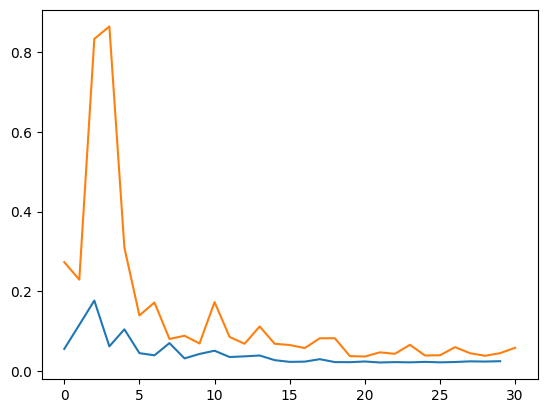

In [9]:
plt.plot(train_losses[1:], label='Training loss')
plt.plot(validation_losses[0:], label='Validation loss')

In [10]:
saved_model_path = 'models/' + name + '.pt'
model.load_state_dict(torch.load(saved_model_path))

<All keys matched successfully>

MSE Loss: 0.016322756186127663


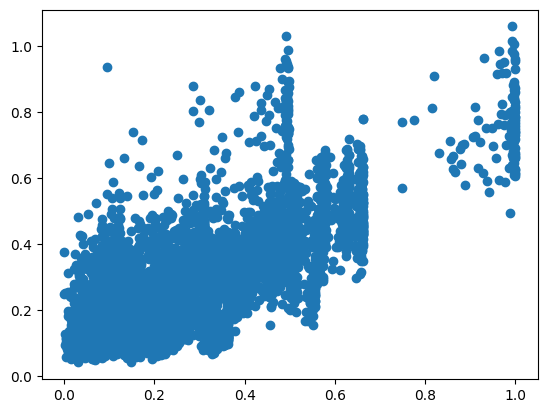

In [11]:
y, predictions = score(model, train_loader, device)
plt.scatter(x = y, y = predictions)

MSE Loss: 0.018155056983232498


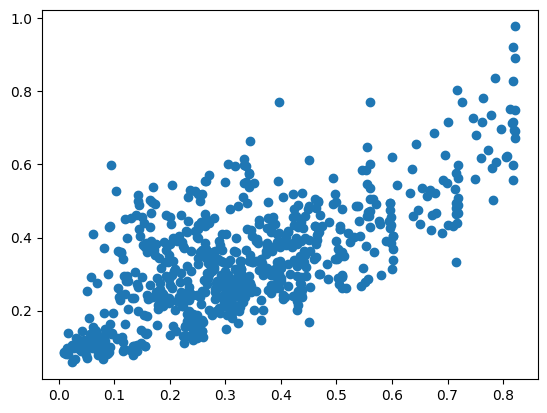

In [12]:
y, predictions = score(model, test_loader, device)
plt.scatter(x = y, y = predictions)

In [12]:
batch_size = 32
distance = 'L1'
distance_scaling = 'counts_density'
train_loader, val_loader, test_loader = prepare_dataloader_distance_scale(hom_counts_path, dataset, batch_size=32, dist=distance, device = device, scaling = distance_scaling, scale_y=True)
hid_size = 32
emb_size = n_homs
lr = 0.01

In [14]:
# Prepare the model: GCN3
name = 'GCN3'
model = GCN3(input_features=dataset.num_node_features, hidden_channels=hid_size, output_embeddings=emb_size, name=name, dist=distance).to(device)
#model = GCN_k_m(input_features=dataset.num_node_features, hidden_channels=hid_size, output_embeddings=emb_size, n_conv_layers=2, n_linear_layers=1, p=0.2, name = name, apply_relu_conv=False, dist='cosine', mlp_dist=True).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.MSELoss().to(device)

train_losses, validation_losses = training_loop(model, train_loader, optimizer, criterion, val_loader, epoch_number=100, patience=10, return_losses=True)

Epoch: 10 | Time for 10 epochs: 0m 48s
	Train Loss: 0.051
	 Val. Loss: 0.016
Epoch: 20 | Time for 10 epochs: 1m 6s
	Train Loss: 0.032
	 Val. Loss: 0.068
Early stopping triggered at epoch 24
Best epoch was 13


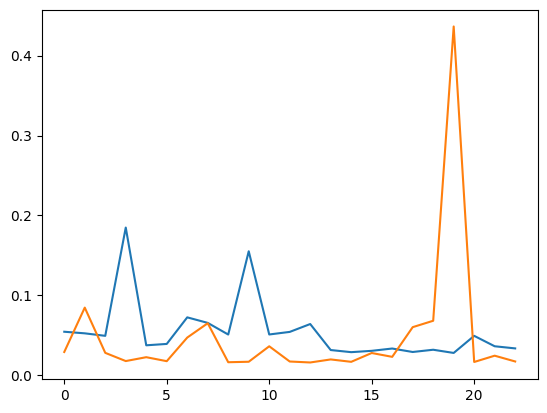

In [15]:
plt.plot(train_losses[1:], label='Training loss')
plt.plot(validation_losses[1:], label='Validation loss')

In [16]:
saved_model_path = 'models/' + name + '.pt'
model.load_state_dict(torch.load(saved_model_path))

<All keys matched successfully>

MSE Loss: 0.02224111184477806


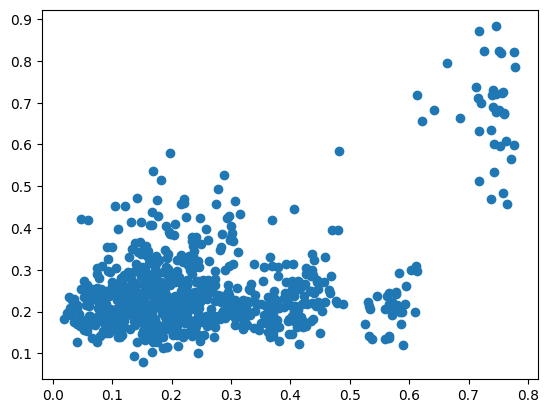

In [19]:
y, predictions = score(model, test_loader, device)
plt.scatter(x = y, y = predictions)

Using all dataset runs.

In [13]:
# Load the homomorphism counts vectors:
name_dataset = 'ENZYMES'
n_homs=44
hom_counts_path = 'data/homomorphism_counts/' + name_dataset + "_" + str(n_homs) + ".homson"
if not os.path.exists(hom_counts_path):
    raise FileNotFoundError(f"The file '{hom_counts_path}' was not found.")

# Load dataset
dataset = TUDataset(root='/tmp/ENZYMES', name='ENZYMES', pre_transform=Add_ID_Count_Neighbours(), use_node_attr=True)

In [14]:
seed = 20224
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

batch_size = 32
distance = 'L1'
distance_scaling = 'counts'
train_loader, val_loader, test_loader = prepare_dataloader_distance_scale(hom_counts_path, dataset, batch_size=32, dist=distance, device = device, scaling = distance_scaling, scale_y=True)
hid_size = 32
emb_size = n_homs
lr = 0.01

In [15]:
# Prepare the model: GCN3
name = 'GCN3_batch_norm'
model = GCN3(input_features=dataset.num_node_features, hidden_channels=hid_size, output_embeddings=emb_size, name=name, dist=distance).to(device)
#model = GCN_k_m(input_features=dataset.num_node_features, hidden_channels=hid_size, output_embeddings=emb_size, n_conv_layers=2, n_linear_layers=1, p=0.2, name = name, apply_relu_conv=False, dist='cosine', mlp_dist=True).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.MSELoss().to(device)

train_losses, validation_losses = training_loop(model, train_loader, optimizer, criterion, val_loader, epoch_number=100, patience=10, return_losses=True)

Epoch: 10 | Time for 10 epochs: 7m 50s
	Train Loss: 0.020
	 Val. Loss: 0.027
Early stopping triggered at epoch 16
Best epoch was 5


(0.0, 0.1)

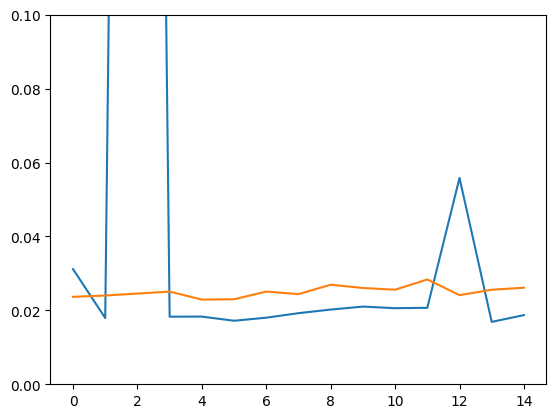

In [21]:
plt.plot(train_losses[1:], label='Training loss')
plt.plot(validation_losses[1:], label='Validation loss')
plt.ylim(0, 0.1)

In [17]:
saved_model_path = 'models/' + name + '.pt'
model.load_state_dict(torch.load(saved_model_path))

<All keys matched successfully>

In [18]:
y, predictions = score(model, test_loader, device)

MSE Loss: 0.01420203223824501


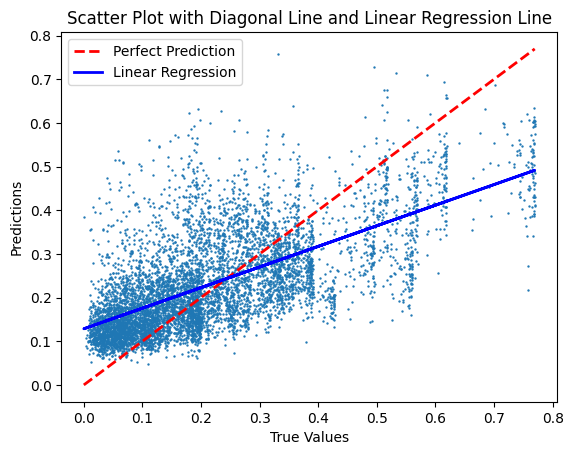

In [19]:

# Assuming you already have y and predictions from your code
# y, predictions = score(model, train_loader, device)

# Scatter plot
plt.scatter(x=y, y=predictions, s=0.5)

# Diagonal line for perfect predictions
plt.plot([min(y), max(y)], [min(y), max(y)], linestyle='--', color='red', linewidth=2, label='Perfect Prediction')

# Linear regression line
regression_line = LinearRegression()
y = np.array(y).reshape(-1, 1)  # Reshape y to a 2D array if it's a 1D array
regression_line.fit(y, predictions)
predictions_line = regression_line.predict(y)
plt.plot(y, predictions_line, color='blue', linewidth=2, label='Linear Regression')

# Customize plot
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.legend()
plt.title('Scatter Plot with Diagonal Line and Linear Regression Line')

# Show the plot
plt.show()

# Use More generic model GCN_k_m
Consistsing of k convolutional layers and m linear layers.

In [6]:
class GCN_k_m(torch.nn.Module):
    """
    Takes as input a pair of graphs which are both fed through k graph convolutional layers and m linear layers (with k >= 1 and m >= 0).
    conv1 -> dropout -> ...         -> convk -> meanpool -> compute dist(x1, x2)
    If apply_relu_conv is True:
    conv1 -> dropout -> relu -> ... -> convk -> meanpool -> compute dist(x1, x2)
    If a number of linear layers m >= 1 is specified:
    conv1 -> dropout -> ...         -> convk -> meanpool -> linear1 -> relu -> ... -> linearm -> compute dist(x1, x2)
    
    If mlp_dist is set to True:
    The distance between the two embedding vectors is obtained by applying a linear transformation on the difference between the two.
    """
    def __init__(self, input_features, hidden_channels, output_embeddings, n_conv_layers, n_linear_layers, name, apply_relu_conv = True, dist = 'L1'):
        super(GCN_k_m, self).__init__()

        if n_conv_layers < 1:
            raise ValueError("Invalid value for n_conv_layers. n_conv_layers should be an integer larger than 0")
        if dist not in ['cosine', 'L1', 'L2']:
            raise ValueError("Invalid value for 'dist'. Expected 'cosine', 'L1', or 'L2'.")
        
        # Details for the architecture
        self.dist = dist
        self.input_features = input_features
        self.output_embeddings = output_embeddings 
        self.name = name

        # Hyper-parameters.
        self.apply_relu_conv = apply_relu_conv # If True applies relu after each convolutional layer
        self.hidden_channels = hidden_channels # Sets dimension of hidden channels
        self.n_conv_layers = n_conv_layers     # Sets number of convolutional layers.
        self.n_linear_layers = n_linear_layers # Sets number of linear layers.

        # GCN and Linear layers employed by the model.
        self.GCN_layers = torch.nn.ModuleList()
        self.Linear_layers = torch.nn.ModuleList()
        self.BN_layers = torch.nn.ModuleList()

        # If no linear layers
        if self.n_linear_layers == 0:
            for i in range(self.n_conv_layers-1): 
                self.GCN_layers.append(GCNConv(input_features, hidden_channels))
                input_features = hidden_channels # From second layer we'll need this.
            # Final GCN layer
            self.GCN_layers.append(GCNConv(input_features, output_embeddings))

        # If there are some linear layers
        else:
            for i in range(self.n_conv_layers): 
                self.GCN_layers.append(GCNConv(input_features, hidden_channels))
                input_features = hidden_channels # From second layer we'll need this.
            # Linear layers
            for i in range(self.n_linear_layers - 1):
                self.Linear_layers.append(Linear(hidden_channels, hidden_channels))
            # Final linear layer
            self.Linear_layers.append(Linear(hidden_channels, output_embeddings))

        # Prepare batch normalization layers to apply after each convolutonal layer.
        for i in range(self.n_conv_layers-1):
            self.BN_layers.append(BatchNorm(hidden_channels))

        # Additional layers
        self.relu = torch.nn.ReLU()
        
        # Define the operation to be performed on the distances based on the the specification.
        if self.dist == 'L1':
            self.pdist = PairwiseDistance(p=1)
        elif self.dist == 'L2':
            self.pdist = PairwiseDistance(p=2)
        elif self.dist == 'cosine':
            self.pdist = CosineSimilarity()

    def forward(self, x1, edge_index1, batch1, x2, edge_index2, batch2): # Need a way to extract these from dataloader

        # 1. Obtain node embeddings for graph 1 and 2
        for i, gcn_layer in enumerate(self.GCN_layers):
            x1 = gcn_layer(x1, edge_index1)
            # x1 = self.conv_dropout(x1)
            x2 = gcn_layer(x2, edge_index2)
            # x2 = self.conv_dropout(x2)

            if i != (self.n_conv_layers-1): # Do not apply batch normalization or ReLu after the last convolutional layer.
                if self.apply_relu_conv:
                    x1 = self.relu(x1)
                    x2 = self.relu(x2)
                x1 = self.BN_layers[i](x1) 
                x2 = self.BN_layers[i](x2)
        
        # 2. Readout layer followed by Linear layers.
        x1 = global_mean_pool(x1, batch1)
        x1 = torch.nn.functional.dropout(x1, p=0.5)
        x2 = global_mean_pool(x2, batch2)
        x2 = torch.nn.functional.dropout(x2, p=0.5)

        for i, layer in enumerate(self.Linear_layers):
            x1 = layer(x1)
            x2 = layer(x2)
            if i != self.n_linear_layers: # Do not apply ReLu after the final linear layer
                x1 = self.relu(x1)
                x2 = self.relu(x2)

        # Compute the corresponding distance between the embeddings.
        if self.dist == 'cosine':
            vdist = 1 - self.pdist(x1, x2)
        else:
            vdist = self.pdist(x1, x2)
        return vdist
    
    def save(self):
        """
        Saves the model state dictionary in models folder
        """
        path = 'models/' + self.name + '.pt'
        torch.save(self.state_dict(), path)

In [7]:
seed = 20224
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

batch_size = 32
distance = 'L1'
distance_scaling = 'counts'
train_loader, val_loader, test_loader = prepare_dataloader_distance_scale(hom_counts_path, dataset, batch_size=32, dist=distance, device = device, scaling = distance_scaling, scale_y=True)
hid_size = 32
emb_size = n_homs
lr = 0.01

In [59]:
name = 'GCN_k_m_bnorm3'
model = GCN_k_m(input_features=dataset.num_node_features, hidden_channels=hid_size, output_embeddings=emb_size, n_conv_layers=3, n_linear_layers=1, p = 0, apply_relu_conv=True, name = name, dist='L1', mlp_dist=False)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.MSELoss().to(device)

In [60]:
train_losses, validation_losses = training_loop(model, train_loader, optimizer, criterion, val_loader, epoch_number=100, patience=10, return_losses=True)

Epoch: 10 | Time for 10 epochs: 6m 30s
	Train Loss: 0.083
	 Val. Loss: 0.097
Early stopping triggered at epoch 12
Best epoch was 1


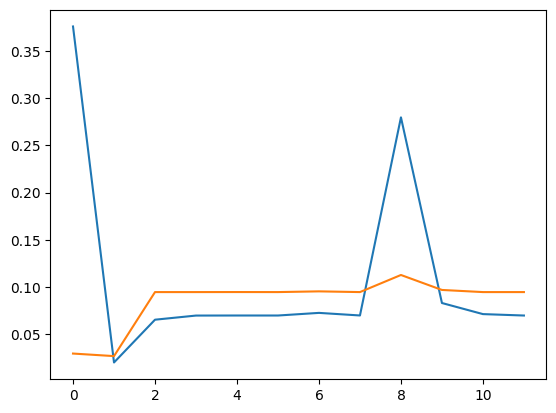

In [65]:
plt.plot(train_losses[0:])
plt.plot(validation_losses[0:])

In [66]:
saved_model_path = 'models/' + name + '.pt'
model.load_state_dict(torch.load(saved_model_path))

<All keys matched successfully>

In [67]:
y, predictions = score(model, test_loader, device)

MSE Loss: 0.016701847314834595


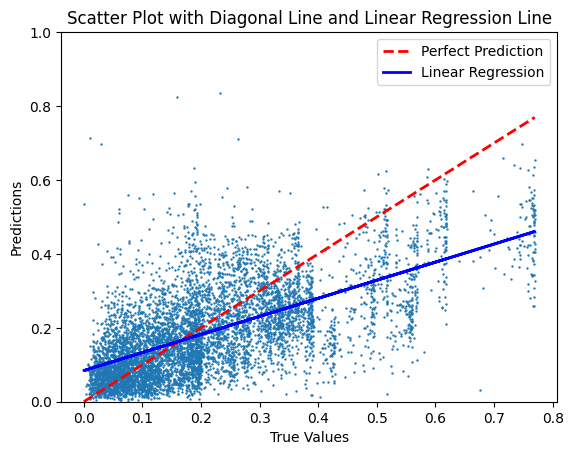

In [69]:
from sklearn.linear_model import LinearRegression

# Assuming you already have y and predictions from your code
# y, predictions = score(model, train_loader, device)

# Scatter plot
plt.scatter(x=y, y=predictions, s=0.5)

# Diagonal line for perfect predictions
plt.plot([min(y), max(y)], [min(y), max(y)], linestyle='--', color='red', linewidth=2, label='Perfect Prediction')

# Linear regression line
regression_line = LinearRegression()
y = np.array(y).reshape(-1, 1)  # Reshape y to a 2D array if it's a 1D array
regression_line.fit(y, predictions)
predictions_line = regression_line.predict(y)
plt.plot(y, predictions_line, color='blue', linewidth=2, label='Linear Regression')
plt.ylim(0, 1)
# Customize plot
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.legend()
plt.title('Scatter Plot with Diagonal Line and Linear Regression Line')

# Show the plot
plt.show()

Try without Linear Layer

In [70]:
seed = 20224
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

batch_size = 32
distance = 'L1'
distance_scaling = 'counts'
train_loader, val_loader, test_loader = prepare_dataloader_distance_scale(hom_counts_path, dataset, batch_size=32, dist=distance, device = device, scaling = distance_scaling, scale_y=True)
hid_size = 32
emb_size = n_homs
lr = 0.01

In [71]:
name = 'GCN_3_0_bnorm'
model = GCN_k_m(input_features=dataset.num_node_features, hidden_channels=hid_size, output_embeddings=emb_size, n_conv_layers=3, n_linear_layers=0, p = 0, apply_relu_conv=True, name = name, dist='L1', mlp_dist=False)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.MSELoss().to(device)

In [72]:
train_losses, validation_losses = training_loop(model, train_loader, optimizer, criterion, val_loader, epoch_number=100, patience=10, return_losses=True)

Epoch: 10 | Time for 10 epochs: 6m 31s
	Train Loss: 0.021
	 Val. Loss: 0.022
Epoch: 20 | Time for 10 epochs: 7m 30s
	Train Loss: 0.021
	 Val. Loss: 0.025
Early stopping triggered at epoch 20
Best epoch was 9


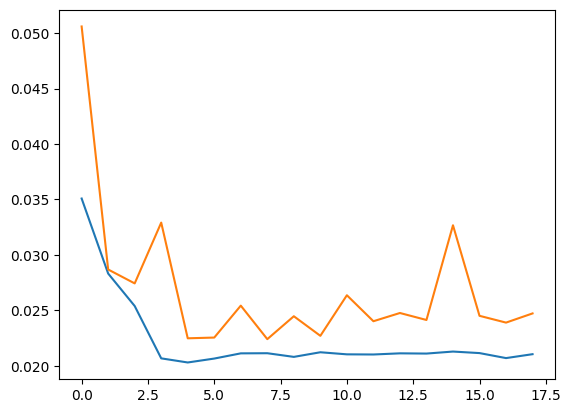

In [76]:
plt.plot(train_losses[2:])
plt.plot(validation_losses[2:])

In [77]:
saved_model_path = 'models/' + name + '.pt'
model.load_state_dict(torch.load(saved_model_path))

<All keys matched successfully>

In [78]:
y, predictions = score(model, test_loader, device)

MSE Loss: 0.011986620724201202


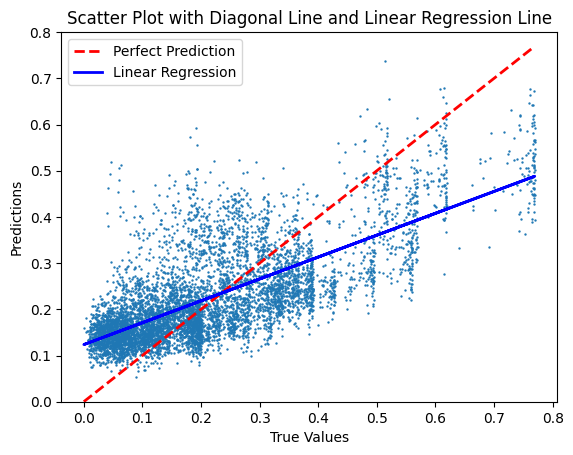

In [80]:
from sklearn.linear_model import LinearRegression

# Assuming you already have y and predictions from your code
# y, predictions = score(model, train_loader, device)

# Scatter plot
plt.scatter(x=y, y=predictions, s=0.5)

# Diagonal line for perfect predictions
plt.plot([min(y), max(y)], [min(y), max(y)], linestyle='--', color='red', linewidth=2, label='Perfect Prediction')

# Linear regression line
regression_line = LinearRegression()
y = np.array(y).reshape(-1, 1)  # Reshape y to a 2D array if it's a 1D array
regression_line.fit(y, predictions)
predictions_line = regression_line.predict(y)
plt.plot(y, predictions_line, color='blue', linewidth=2, label='Linear Regression')
plt.ylim(0, 0.8)
# Customize plot
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.legend()
plt.title('Scatter Plot with Diagonal Line and Linear Regression Line')

# Show the plot
plt.show()

# Cosine COUNTS (No Linear Layers)

In [100]:
seed = 20224
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

batch_size = 32
distance = 'cosine'
distance_scaling = 'counts'
train_loader, val_loader, test_loader = prepare_dataloader_distance_scale(hom_counts_path, dataset, batch_size=32, dist=distance, device = device, scaling = distance_scaling, scale_y=True)
hid_size = 32
emb_size = n_homs
lr = 0.01

In [101]:
name = 'GCN_3_0_bnorm_cosine'
model = GCN_k_m(input_features=dataset.num_node_features, hidden_channels=hid_size, output_embeddings=emb_size, n_conv_layers=3, n_linear_layers=0, p = 0, apply_relu_conv=True, name = name, dist='cosine', mlp_dist=False)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.MSELoss().to(device)

In [102]:
train_losses, validation_losses = training_loop(model, train_loader, optimizer, criterion, val_loader, epoch_number=100, patience=10, return_losses=True)

Epoch: 10 | Time for 10 epochs: 9m 3s
	Train Loss: 0.202
	 Val. Loss: 0.204
Early stopping triggered at epoch 19
Best epoch was 8


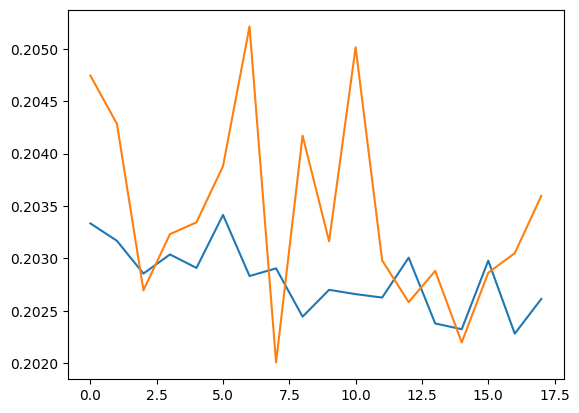

In [103]:
plt.plot(train_losses[1:])
plt.plot(validation_losses[1:])

In [104]:
saved_model_path = 'models/' + name + '.pt'
model.load_state_dict(torch.load(saved_model_path))

<All keys matched successfully>

In [105]:
y, predictions = score(model, test_loader, device)

MSE Loss: 0.20259523391723633


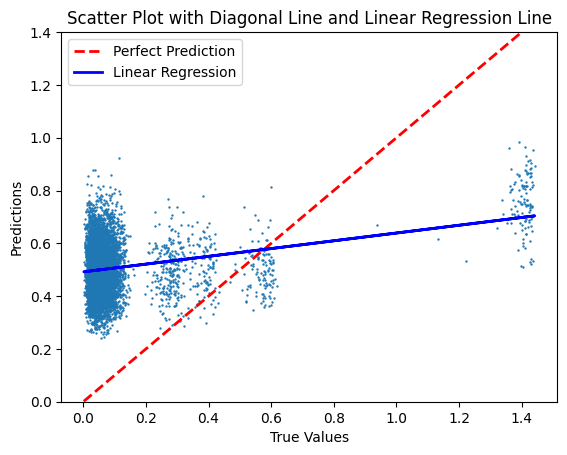

In [106]:
from sklearn.linear_model import LinearRegression

# Assuming you already have y and predictions from your code
# y, predictions = score(model, train_loader, device)

# Scatter plot
plt.scatter(x=y, y=predictions, s=0.5)

# Diagonal line for perfect predictions
plt.plot([min(y), max(y)], [min(y), max(y)], linestyle='--', color='red', linewidth=2, label='Perfect Prediction')

# Linear regression line
regression_line = LinearRegression()
y = np.array(y).reshape(-1, 1)  # Reshape y to a 2D array if it's a 1D array
regression_line.fit(y, predictions)
predictions_line = regression_line.predict(y)
plt.plot(y, predictions_line, color='blue', linewidth=2, label='Linear Regression')
plt.ylim(0, 1.4)
# Customize plot
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.legend()
plt.title('Scatter Plot with Diagonal Line and Linear Regression Line')

# Show the plot
plt.show()

# L2 (No linear layers)

In [107]:
seed = 20224
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

batch_size = 32
distance = 'L2'
distance_scaling = 'counts'
train_loader, val_loader, test_loader = prepare_dataloader_distance_scale(hom_counts_path, dataset, batch_size=32, dist=distance, device = device, scaling = distance_scaling, scale_y=True)
hid_size = 32
emb_size = n_homs
lr = 0.01

In [108]:
name = 'GCN_3_0_bnorm_L2'
model = GCN_k_m(input_features=dataset.num_node_features, hidden_channels=hid_size, output_embeddings=emb_size, n_conv_layers=3, n_linear_layers=0, p = 0, apply_relu_conv=True, name = name, dist='L2', mlp_dist=False)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.MSELoss().to(device)

In [109]:
train_losses, validation_losses = training_loop(model, train_loader, optimizer, criterion, val_loader, epoch_number=100, patience=10, return_losses=True)

Epoch: 10 | Time for 10 epochs: 6m 44s
	Train Loss: 0.016
	 Val. Loss: 0.024
Early stopping triggered at epoch 18
Best epoch was 7


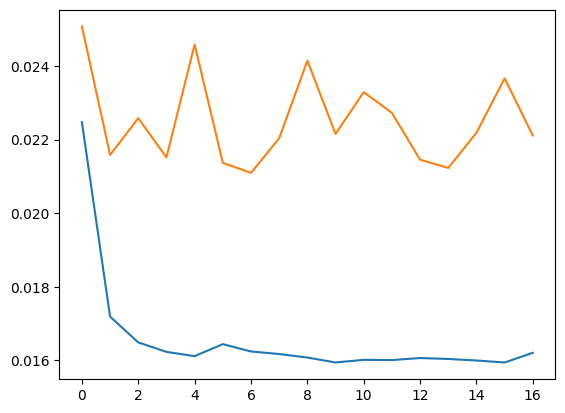

In [110]:
plt.plot(train_losses[1:])
plt.plot(validation_losses[1:])

In [111]:
saved_model_path = 'models/' + name + '.pt'
model.load_state_dict(torch.load(saved_model_path))

<All keys matched successfully>

In [112]:
y, predictions = score(model, test_loader, device)

MSE Loss: 0.011115007102489471


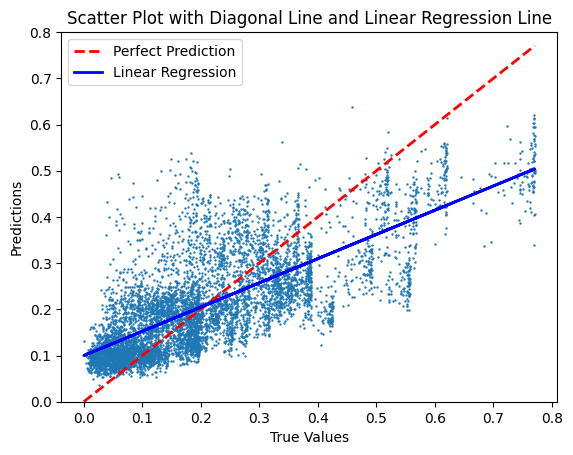

In [113]:
from sklearn.linear_model import LinearRegression

# Assuming you already have y and predictions from your code
# y, predictions = score(model, train_loader, device)

# Scatter plot
plt.scatter(x=y, y=predictions, s=0.5)

# Diagonal line for perfect predictions
plt.plot([min(y), max(y)], [min(y), max(y)], linestyle='--', color='red', linewidth=2, label='Perfect Prediction')

# Linear regression line
regression_line = LinearRegression()
y = np.array(y).reshape(-1, 1)  # Reshape y to a 2D array if it's a 1D array
regression_line.fit(y, predictions)
predictions_line = regression_line.predict(y)
plt.plot(y, predictions_line, color='blue', linewidth=2, label='Linear Regression')
plt.ylim(0, 0.8)
# Customize plot
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.legend()
plt.title('Scatter Plot with Diagonal Line and Linear Regression Line')

# Show the plot
plt.show()

# L2 (with Linear layer)

In [114]:
seed = 20224
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

batch_size = 32
distance = 'L2'
distance_scaling = 'counts'
train_loader, val_loader, test_loader = prepare_dataloader_distance_scale(hom_counts_path, dataset, batch_size=32, dist=distance, device = device, scaling = distance_scaling, scale_y=True)
hid_size = 32
emb_size = n_homs
lr = 0.01

In [115]:
name = 'GCN_3_1_bnorm_L2_linear'
model = GCN_k_m(input_features=dataset.num_node_features, hidden_channels=hid_size, output_embeddings=emb_size, n_conv_layers=3, n_linear_layers=1, p = 0, apply_relu_conv=True, name = name, dist='L2', mlp_dist=False)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.MSELoss().to(device)

In [116]:
train_losses, validation_losses = training_loop(model, train_loader, optimizer, criterion, val_loader, epoch_number=100, patience=10, return_losses=True)

Epoch: 10 | Time for 10 epochs: 5m 51s
	Train Loss: 0.016
	 Val. Loss: 0.025
Epoch: 20 | Time for 10 epochs: 6m 16s
	Train Loss: 0.017
	 Val. Loss: 0.026
Early stopping triggered at epoch 21
Best epoch was 10


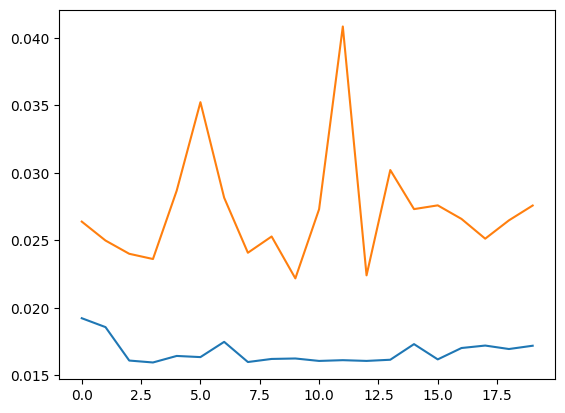

In [117]:
plt.plot(train_losses[1:])
plt.plot(validation_losses[1:])

In [118]:
saved_model_path = 'models/' + name + '.pt'
model.load_state_dict(torch.load(saved_model_path))

<All keys matched successfully>

In [119]:
y, predictions = score(model, test_loader, device)

MSE Loss: 0.014720626175403595


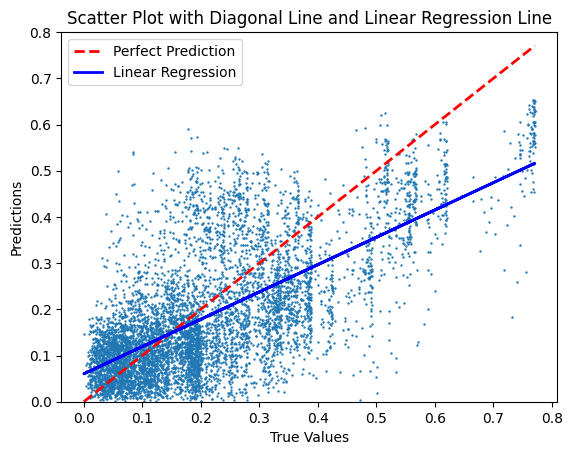

In [120]:
from sklearn.linear_model import LinearRegression

# Assuming you already have y and predictions from your code
# y, predictions = score(model, train_loader, device)

# Scatter plot
plt.scatter(x=y, y=predictions, s=0.5)

# Diagonal line for perfect predictions
plt.plot([min(y), max(y)], [min(y), max(y)], linestyle='--', color='red', linewidth=2, label='Perfect Prediction')

# Linear regression line
regression_line = LinearRegression()
y = np.array(y).reshape(-1, 1)  # Reshape y to a 2D array if it's a 1D array
regression_line.fit(y, predictions)
predictions_line = regression_line.predict(y)
plt.plot(y, predictions_line, color='blue', linewidth=2, label='Linear Regression')
plt.ylim(0, 0.8)
# Customize plot
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.legend()
plt.title('Scatter Plot with Diagonal Line and Linear Regression Line')

# Show the plot
plt.show()

# Add More Convolutional Layers on L1

In [14]:
seed = 20224
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

batch_size = 32
distance = 'L2'
distance_scaling = 'counts'
train_loader, val_loader, test_loader = prepare_dataloader_distance_scale(hom_counts_path, dataset, batch_size=32, dist=distance, device = device, scaling = distance_scaling, scale_y=True)
hid_size = 32
emb_size = n_homs
lr = 0.01

In [15]:
name = 'GCN_3_2_bnorm3'
model = GCN_k_m(input_features=dataset.num_node_features, hidden_channels=hid_size, output_embeddings=emb_size, n_conv_layers=4, n_linear_layers=1,  apply_relu_conv=True, name = name, dist='L2')
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.MSELoss().to(device)

In [16]:
train_losses, validation_losses = training_loop(model, train_loader, optimizer, criterion, val_loader, epoch_number=100, patience=10, return_losses=True)

Epoch: 10 | Time for 10 epochs: 9m 34s
	Train Loss: 0.016
	 Val. Loss: 0.025
Epoch: 20 | Time for 10 epochs: 7m 58s
	Train Loss: 0.015
	 Val. Loss: 12.853
Epoch: 30 | Time for 10 epochs: 7m 49s
	Train Loss: 0.015
	 Val. Loss: 0.024
Epoch: 40 | Time for 10 epochs: 7m 47s
	Train Loss: 0.015
	 Val. Loss: 0.022
Early stopping triggered at epoch 44
Best epoch was 33


(0.0, 0.05)

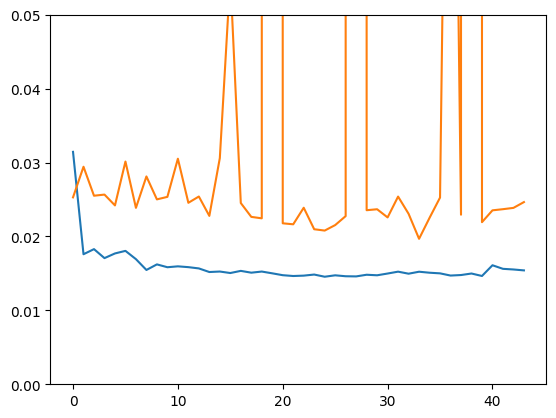

In [22]:
plt.plot(train_losses[0:])
plt.plot(validation_losses[0:])
plt.ylim(0, 0.05)

In [23]:
saved_model_path = 'models/' + name + '.pt'
model.load_state_dict(torch.load(saved_model_path))

<All keys matched successfully>

In [24]:
y, predictions = score(model, test_loader, device)

MSE Loss: 0.010492960922420025


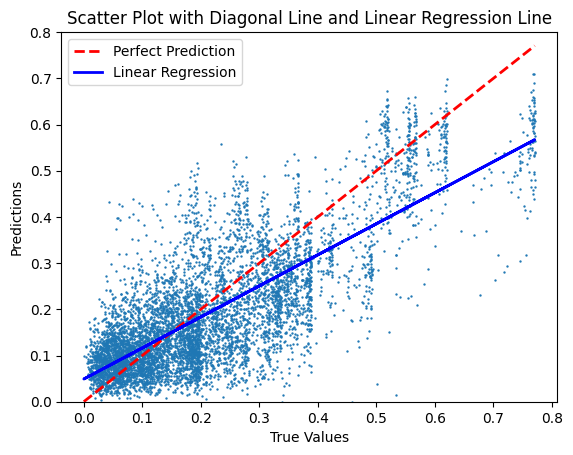

In [26]:
from sklearn.linear_model import LinearRegression

# Assuming you already have y and predictions from your code
# y, predictions = score(model, train_loader, device)

# Scatter plot
plt.scatter(x=y, y=predictions, s=0.5)

# Diagonal line for perfect predictions
plt.plot([min(y), max(y)], [min(y), max(y)], linestyle='--', color='red', linewidth=2, label='Perfect Prediction')

# Linear regression line
regression_line = LinearRegression()
y = np.array(y).reshape(-1, 1)  # Reshape y to a 2D array if it's a 1D array
regression_line.fit(y, predictions)
predictions_line = regression_line.predict(y)
plt.plot(y, predictions_line, color='blue', linewidth=2, label='Linear Regression')
plt.ylim(0, 0.8)
# Customize plot
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.legend()
plt.title('Scatter Plot with Diagonal Line and Linear Regression Line')

# Show the plot
plt.show()